In [94]:
from typing import List
import numpy as np
import pandas as pd
from pynwb import NWBFile, TimeSeries
from pynwb.behavior import BehavioralEvents
from pynwb.file import Subject
from pynwb.ecephys import ElectrodeGroup
import nixio
import regex as re
from usz_neuro_conversion.common import (
    SessionContext,
    NixContext,
    get_metadata_row,
    read_nix,
    get_date,
    write_nwb,
    standardize_sex,
    find_nix_files,
)
import matplotlib.pyplot as plt
from usz_neuro_conversion.common import create_nwb_io_for_reading, NwbContext

In [95]:
context = NwbContext(subject=1, session=1, project="Human_MTL_units_scalp_eeg_and_ieeg_verbal_wm")
io = create_nwb_io_for_reading(context)
nwb = io.read()

In [189]:
unit_count = len(nwb.units["id"])
trial_count = len(nwb.units["obs_intervals"][0])
spike_times = [
    [nwb.units.get_unit_spike_times(unit, list(interval)) for interval in nwb.units.get_unit_obs_intervals(unit)] for
    unit in range(unit_count)]
spike_intervals = [
    [list(zip(interval, interval[1:])) for interval in unit] for unit in spike_times
]
spike_times = [
    np.concatenate(times) for times in spike_times
]

unit = spike_intervals[-1]
interval = unit[-1]
for lhs, rhs in interval:
    print("lhs:", lhs)
    print("rhs:", rhs)

spike_intervals = [
    [[rhs - lhs for lhs, rhs in interval] for interval in unit] for unit in spike_intervals
]
unit = spike_intervals[-1]
interval = unit[-1]
for diff in interval:
    print(diff)

lhs: 785.540955000004
rhs: 785.6110175000067
lhs: 785.6110175000067
rhs: 785.6703612499987
0.07006250000267755
0.05934374999196734


In [210]:
df = pd.DataFrame(
    [],
    columns=[
        "unit",
        "trial",
        "interval_index",
        "spike_interval",
    ],
).astype({
    "unit": int,
    "trial": int,
    "interval_index": int,
    "spike_interval": float,
})
for unit_index, unit in enumerate(spike_intervals):
    for trial_index, interval in enumerate(unit):
        units = [unit_index] * len(interval)
        trials = [trial_index] * len(interval)
        intervals = list(range(len(interval)))
        df = pd.concat([
            df,
            pd.DataFrame(
                np.array([
                    units,
                    trials,
                    intervals,
                    interval,
                ]).T,
                columns=[
                    "unit",
                    "trial",
                    "interval_index",
                    "spike_interval",
                ]
            ).astype({
                "unit": int,
                "trial": int,
                "interval_index": int,
                "spike_interval": float,
            })
        ])

Text(0.5, 1.0, 'Spike histogram (100 bins)')

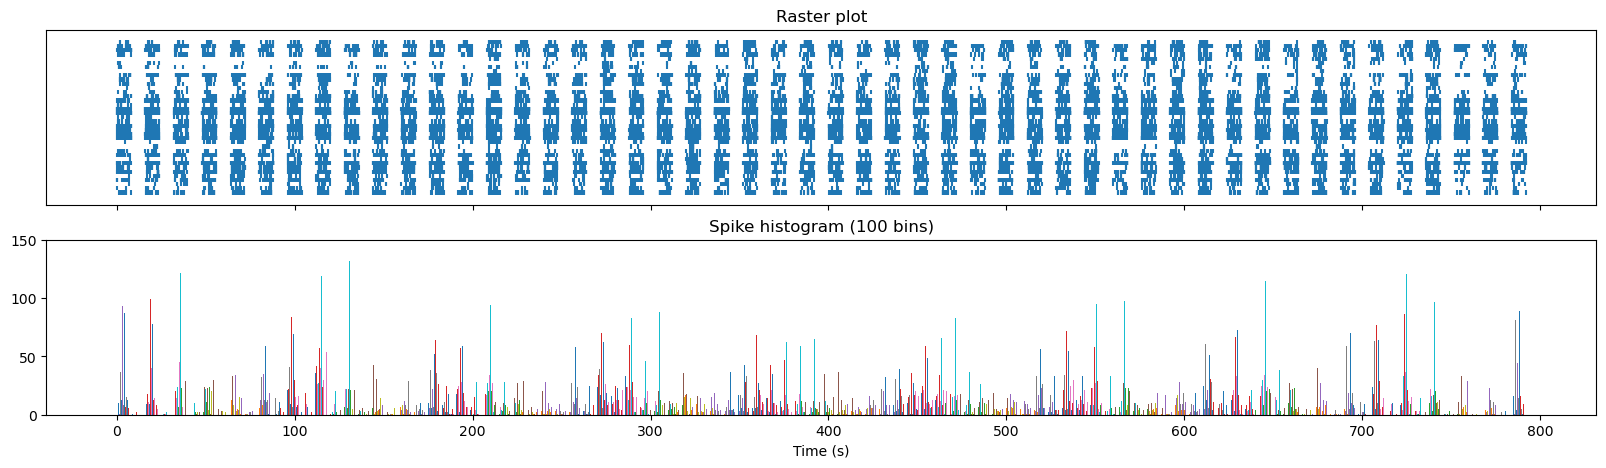

In [140]:
fig, ax = plt.subplots(2, 1, sharex="all")
fig.set_size_inches(20, 5)
plt.xlabel("Time (s)")

ax[0].eventplot(spike_times)

ax[0].set_yticks([])
ax[0].set_title(f"Raster plot")

ax[1].hist(spike_times, bins=100)
ax[1].set_title(f"Spike histogram (100 bins)")

In [218]:
project = "Human_MTL_units_scalp_EEG_and_iEEG_verbal_WM"
for subject, sessions in find_nix_files(project).items():
    df = pd.DataFrame(
        [],
        columns=[
            "session",
            "unit",
            "trial",
            "interval_index",
            "spike_interval",
        ],
    ).astype({
        "session": int,
        "unit": int,
        "trial": int,
        "interval_index": int,
        "spike_interval": float,
    })
    for session, _ in sessions.items():
        print(f"Converting subject {subject} session {session}")
        context = NixContext(subject=subject, session=session, project=project)
        io = create_nwb_io_for_reading(context)
        nwb = io.read()
        if nwb.units is None:
            continue
        unit_count = len(nwb.units["id"])
        trial_count = len(nwb.units["obs_intervals"][0])
        spike_times = [
            [nwb.units.get_unit_spike_times(unit, list(interval)) for interval in
             nwb.units.get_unit_obs_intervals(unit)] for
            unit in range(unit_count)]
        spike_intervals = [
            [list(zip(interval, interval[1:])) for interval in unit] for unit in spike_times
        ]
        spike_intervals = [
            [[rhs - lhs for lhs, rhs in interval] for interval in unit] for unit in spike_intervals
        ]
        for unit_index, unit in enumerate(spike_intervals):
            for trial_index, interval in enumerate(unit):
                data_count = len(interval)
                sessions = [session] * data_count
                units = [unit_index + 1] * data_count
                trials = [trial_index + 1] * data_count
                intervals = list(range(data_count))
                df = pd.concat([
                    df,
                    pd.DataFrame(
                        np.array([
                            sessions,
                            units,
                            trials,
                            intervals,
                            interval,
                        ]).T,
                        columns=[
                            "session",
                            "unit",
                            "trial",
                            "interval_index",
                            "spike_interval",
                        ]
                    ).astype({
                        "session": int,
                        "unit": int,
                        "trial": int,
                        "interval_index": int,
                        "spike_interval": float,
                    })
                ])
        io.close()
    df.to_csv(f"../out/intervals/spike_intervals_{subject}.csv", index=False)

Converting subject 1 session 1
Converting subject 1 session 2
Converting subject 1 session 3
Converting subject 1 session 4
Converting subject 2 session 1
Converting subject 2 session 2
Converting subject 2 session 3
Converting subject 2 session 4
Converting subject 2 session 5
Converting subject 2 session 6
Converting subject 2 session 7
Converting subject 3 session 1
Converting subject 3 session 2
Converting subject 3 session 3
Converting subject 4 session 1
Converting subject 4 session 2
Converting subject 5 session 1
Converting subject 5 session 2
Converting subject 5 session 3
Converting subject 6 session 1
Converting subject 6 session 2
Converting subject 6 session 3
Converting subject 6 session 4
Converting subject 6 session 5
Converting subject 6 session 6
Converting subject 6 session 7
Converting subject 7 session 1
Converting subject 7 session 2
Converting subject 7 session 3
Converting subject 7 session 4
Converting subject 8 session 1
Converting subject 8 session 2
Converti

In [93]:
io.close()